# First very rough try at Gaussian process through Earth-Moon data

by *Niels J. de Winter* **n.j.de.winter@vu.nl**

In [55]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import cholesky, cho_solve, solve_triangular
# from numpy.linalg import inv, cholesky, solve
# from scipy.linalg import cho_solve
from scipy.optimize import minimize, LinearConstraint
from scipy.interpolate import interp1d

## Input manually estimated data based on Williams et al. (2000)

In [46]:
# Manually estimated data with rough error bars from the Figure 2 in Williams et al. (2000)
data = [
    {"Age (Ma)": 620, "Age error": 30, "Days/year": 400, "Days/year error": 10, "Hours/day": 22.0, "Hours/day error": 0.4, "Data type": "Elatina–Reynella"},
    {"Age (Ma)": 600, "Age error": 25, "Days/year": 410, "Days/year error": 10, "Hours/day": 21.4, "Hours/day error": 0.3, "Data type": "Stromatolites, max"},
    {"Age (Ma)": 550, "Age error": 20, "Days/year": 417, "Days/year error": 5, "Hours/day": 21.0, "Hours/day error": 0.2, "Data type": "Stromatolites, mean"},
    {"Age (Ma)": 500, "Age error": 15, "Days/year": 415, "Days/year error": 5, "Hours/day": 21.1, "Hours/day error": 0.2, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 450, "Age error": 10, "Days/year": 410, "Days/year error": 5, "Hours/day": 21.3, "Hours/day error": 0.2, "Data type": "Bivalves, mean"},
    {"Age (Ma)": 400, "Age error": 5, "Days/year": 400, "Days/year error": 5, "Hours/day": 22.0, "Hours/day error": 0.2, "Data type": "Corals, max"},
    {"Age (Ma)": 380, "Age error": 3, "Days/year": 395, "Days/year error": 10, "Hours/day": 22.2, "Hours/day error": 0.3, "Data type": "Corals, mean"},
    {"Age (Ma)": 300, "Age error": 2, "Days/year": 385, "Days/year error": 10, "Hours/day": 22.6, "Hours/day error": 0.3, "Data type": "Corals, mean"},
    {"Age (Ma)": 250, "Age error": 1, "Days/year": 375, "Days/year error": 10, "Hours/day": 23.3, "Hours/day error": 0.3, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 150, "Age error": 1, "Days/year": 370, "Days/year error": 10, "Hours/day": 23.5, "Hours/day error": 0.3, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 0, "Age error": 0, "Days/year": 365.25, "Days/year error": 0, "Hours/day": 24.0, "Hours/day error": 0, "Data type": "Modern value"},
]

df = pd.DataFrame(data)
df.head()

,Age (Ma),Age error,Days/year,Days/year error,Hours/day,Hours/day error,Data type
0,620,30,400.0,10,22.0,0.4,Elatina–Reynella
1,600,25,410.0,10,21.4,0.3,"Stromatolites, max"
2,550,20,417.0,5,21.0,0.2,"Stromatolites, mean"
3,500,15,415.0,5,21.1,0.2,"Brachiopods, max"
4,450,10,410.0,5,21.3,0.2,"Bivalves, mean"


## Plot dummy data

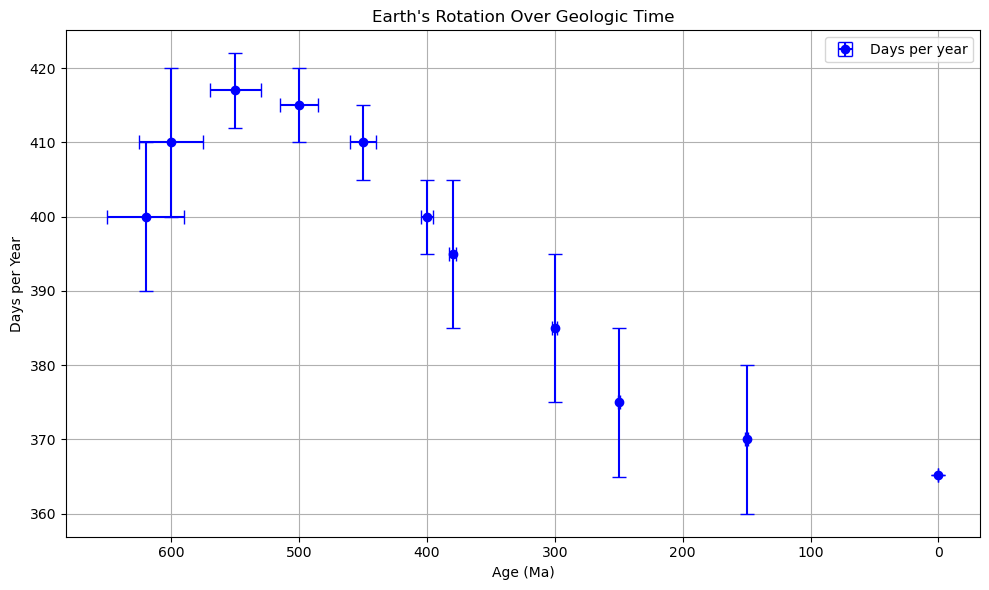

In [48]:
# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(df["Age (Ma)"], df["Days/year"], yerr=df["Days/year error"], xerr=df["Age error"],
             fmt='o', color='blue', capsize=5, label="Days per year")

# Invert x-axis (oldest on left)
plt.gca().invert_xaxis()

# Labels and title
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Earth's Rotation Over Geologic Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Test: play around with Gaussian process regression

### Use Radial Basis Function as kernel (no x-uncertainty)
Based on https://medium.com/data-science-at-microsoft/introduction-to-gaussian-process-regression-part-1-the-basics-3cb79d9f155f#b578

Script to play around with hyperparameters without optimization

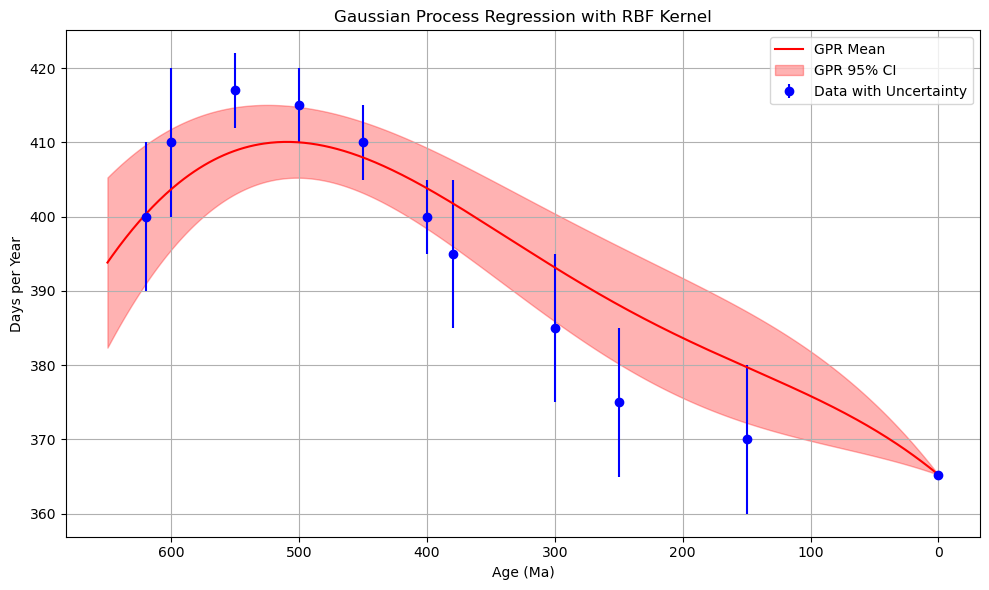

In [36]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_train = df["Days/year"].values.astype(float)
y_error = df["Days/year error"].values.astype(float)

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std

# 2. Define RBF kernel function
def rbf_kernel(X1, X2, lengthscale=1.0, variance=1.0):
    """Radial Basis Function (RBF) kernel"""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + \
             np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

# 3. Set hyperparameters
lengthscale = 2  # Lengthscale of the RBF kernel
variance = 1000 # Variance of the kernel

# 4. Compute kernel matrices
K = rbf_kernel(X_train_norm, X_train_norm, lengthscale, variance) # Covariance matrix
K += np.diag((y_error**2))  # Add individual noise variances
K_inv = inv(K) # Inverse of covariance matrix

# 5. Predict on new input grid
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
K_s = rbf_kernel(X_test_norm, X_train_norm, lengthscale, variance) # Cross-covariance between test and training data
K_ss = rbf_kernel(X_test_norm, X_test_norm, lengthscale, variance) + 1e-8 * np.eye(len(X_test)) # Covariance matrix for test data (adding small noise for numerical stability)

# 6. Posterior mean and covariance
mu_s = K_s @ K_inv @ y_train # Mean prediction
cov_s = K_ss - K_s @ K_inv @ K_s.T # Covariance of the prediction
std_s = np.sqrt(np.diag(cov_s)) # Standard deviation of the prediction

# 7. Plot
plt.figure(figsize=(10, 6))
plt.errorbar(X_train, y_train, yerr=y_error.flatten(), fmt='o', color='blue', label='Data with Uncertainty')
plt.plot(X_test, mu_s, 'r', label="GPR Mean")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='GPR 95% CI')
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.gca().invert_xaxis()
plt.title("Gaussian Process Regression with RBF Kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Use adapted Radial Basis Function kernel to accommodate y-uncertainty
Adapted covariance function for uncertain inputs on both variables from Girard et al. (https://proceedings.neurips.cc/paper_files/paper/2002/hash/f3ac63c91272f19ce97c7397825cc15f-Abstract.html) and Rasmussen et al. (http://www.gaussianprocess.org/gpml/)

Script to play around with hyperparameters without optimization

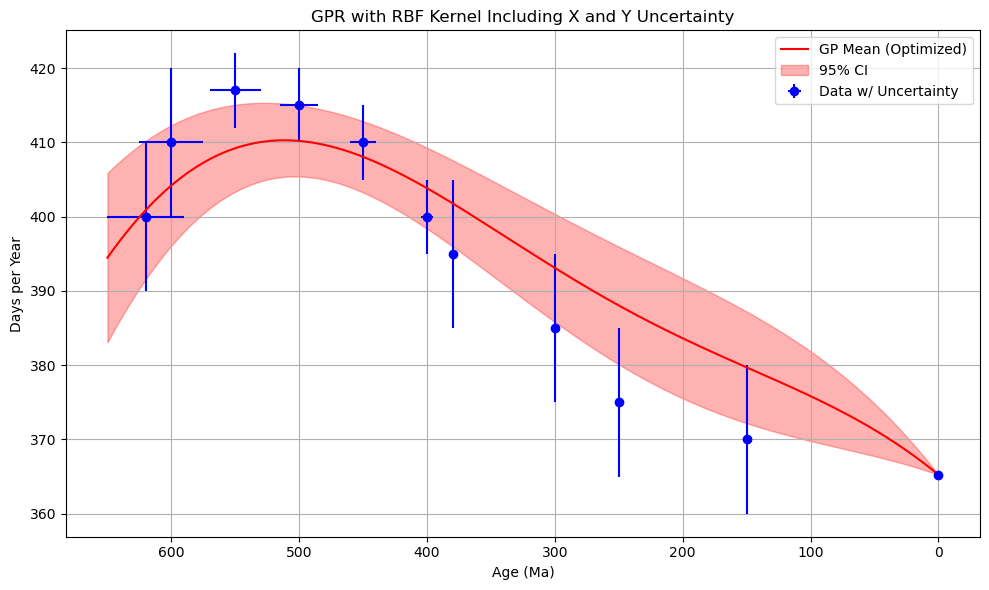

In [49]:
# Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_train = df["Days/year"].values.astype(float)
y_error = df["Days/year error"].values.astype(float)
x_error = df["Age error"].values.astype(float).reshape(-1, 1)

# Normalize inputs
X_mean, X_std = X_train.mean(), X_train.std()
X_train_norm = (X_train - X_mean) / X_std
x_error_norm = x_error / X_std  # Scale x uncertainties too

# Modified RBF kernel including x_error
def rbf_kernel_with_xerr(X1, X2, xerr1, xerr2, lengthscale, variance):
    """RBF kernel that accounts for Gaussian uncertainty in X."""
    # Pairwise squared distance
    sqdist = (X1 - X2.T)**2
    # Total lengthscale squared for each pair
    total_var = lengthscale**2 + xerr1**2 + xerr2.T**2
    scale_factor = (lengthscale**2 / total_var)**0.5
    return variance * scale_factor * np.exp(-0.5 * sqdist / total_var)

# # NLML function (for optimization)
# def nlml(params):
#     lengthscale = np.exp(params[0])
#     variance = np.exp(params[1])
#     noise_var = (y_error**2).flatten()
    
#     K = rbf_kernel_with_xerr(X_train_norm, X_train_norm, x_error_norm, x_error_norm, lengthscale, variance)
#     K += np.diag(noise_var)  # Add measurement noise in y
    
#     try:
#         L = cholesky(K)
#         alpha = solve(L.T, solve(L, y_train))
#         log_det_K = 2.0 * np.sum(np.log(np.diag(L)))
#         return 0.5 * y_train.T @ alpha + 0.5 * log_det_K + 0.5 * len(X_train) * np.log(2 * np.pi)
#     except np.linalg.LinAlgError:
#         return 1e10  # Penalize non-PD matrices

# # Optimize hyperparameters
# res = minimize(nlml, x0=[0.0, 0.0], bounds=[(-5, 5), (-5, 10)], method='L-BFGS-B')
# opt_lengthscale = np.exp(res.x[0])
# opt_variance = np.exp(res.x[1])
# print(f"Optimal lengthscale: {opt_lengthscale:.3f}, variance: {opt_variance:.3f}")

# 3. Set hyperparameters
lengthscale = 2  # Lengthscale of the RBF kernel
variance = 1000 # Variance of the kernel

# === 6. Predictions ===
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
x_error_test = np.zeros_like(X_test_norm)  # Assume no horizontal error for prediction

K = rbf_kernel_with_xerr(X_train_norm, X_train_norm, x_error_norm, x_error_norm, lengthscale, variance)
K += np.diag((y_error**2).flatten() + 1e-6)
K_s = rbf_kernel_with_xerr(X_test_norm, X_train_norm, x_error_test, x_error_norm, lengthscale, variance)
K_ss = rbf_kernel_with_xerr(X_test_norm, X_test_norm, x_error_test, x_error_test, lengthscale, variance) + 1e-8 * np.eye(len(X_test)) # Add small noise for numerical stability

L = cholesky(K)
alpha = solve(L.T, solve(L, y_train))
mu_s = K_s @ alpha
v = solve(L, K_s.T)
cov_s = K_ss - v.T @ v
std_s = np.sqrt(np.clip(np.diag(cov_s), 0, np.inf))

# === 7. Plot ===
plt.figure(figsize=(10, 6))
plt.errorbar(X_train.flatten(), y_train.flatten(),
             xerr=x_error.flatten(), yerr=y_error.flatten(),
             fmt='o', color='blue', label="Data w/ Uncertainty")
plt.plot(X_test, mu_s, 'r', label="GP Mean (Optimized)")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='95% CI')
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("GPR with RBF Kernel Including X and Y Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Optimize hyperparameters

Optimal lengthscale: 12.341, variance: 22026.466


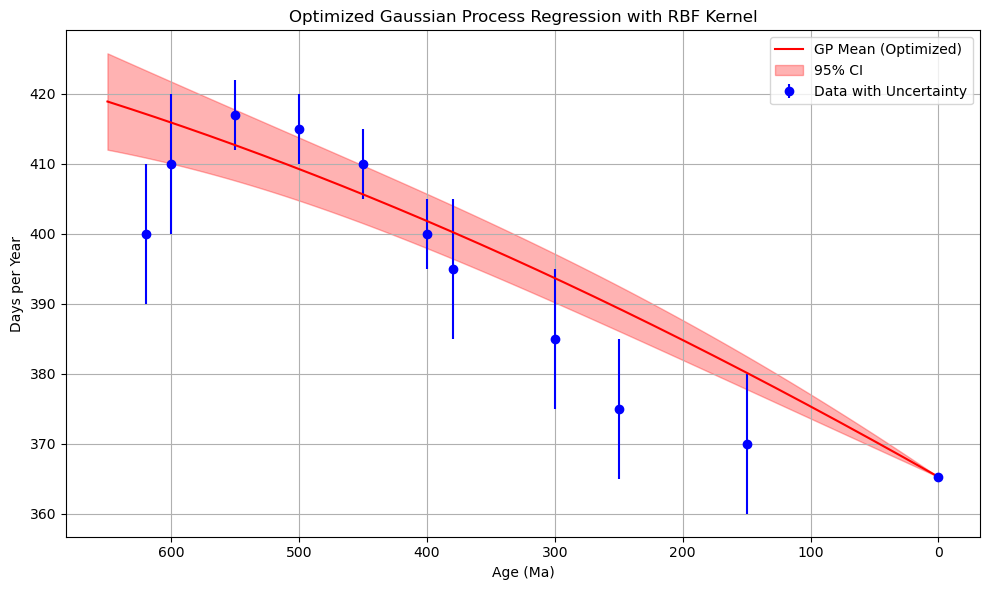

In [50]:
# Negative Log Marginal Likelihood
def nlml(params):
    lengthscale = np.exp(params[0])  # log-param to ensure positivity
    variance = np.exp(params[1])
    noise_var = (y_error ** 2).flatten()

    K = rbf_kernel(X_train_norm, X_train_norm, lengthscale, variance)
    K += np.diag(noise_var)

    try:
        L = cholesky(K)
        alpha = solve(L.T, solve(L, y_train))
        log_det_K = 2.0 * np.sum(np.log(np.diag(L)))
        nlml_value = 0.5 * y_train.T @ alpha + 0.5 * log_det_K + 0.5 * len(X_train) * np.log(2 * np.pi)
        return nlml_value.flatten()[0]
    except np.linalg.LinAlgError:
        return 1e10  # Penalize bad matrix

# Optimize
res = minimize(nlml, x0=[0.0, 0.0], bounds=[(-5, 5), (-5, 10)], method='L-BFGS-B')
opt_lengthscale = np.exp(res.x[0])
opt_variance = np.exp(res.x[1])
print(f"Optimal lengthscale: {opt_lengthscale:.3f}, variance: {opt_variance:.3f}")

# Predict
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
K = rbf_kernel(X_train_norm, X_train_norm, opt_lengthscale, opt_variance)
K += np.diag((y_error**2).flatten() + 1e-6)
K_s = rbf_kernel(X_test_norm, X_train_norm, opt_lengthscale, opt_variance)
K_ss = rbf_kernel(X_test_norm, X_test_norm, opt_lengthscale, opt_variance) + 1e-8 * np.eye(len(X_test))

L = cholesky(K)
alpha = solve(L.T, solve(L, y_train))
mu_s = K_s @ alpha
v = solve(L, K_s.T)
cov_s = K_ss - v.T @ v
std_s = np.sqrt(np.clip(np.diag(cov_s), 0, np.inf))

# 7. Plot
plt.figure(figsize=(10, 6))
plt.errorbar(X_train.flatten(), y_train.flatten(), yerr=y_error.flatten(), fmt='o', label="Data with Uncertainty", color='blue')
plt.plot(X_test, mu_s, 'r', label="GP Mean (Optimized)")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='95% CI')
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Optimized Gaussian Process Regression with RBF Kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Optimize with x error

Optimal lengthscale: 12.341, variance: 22026.466


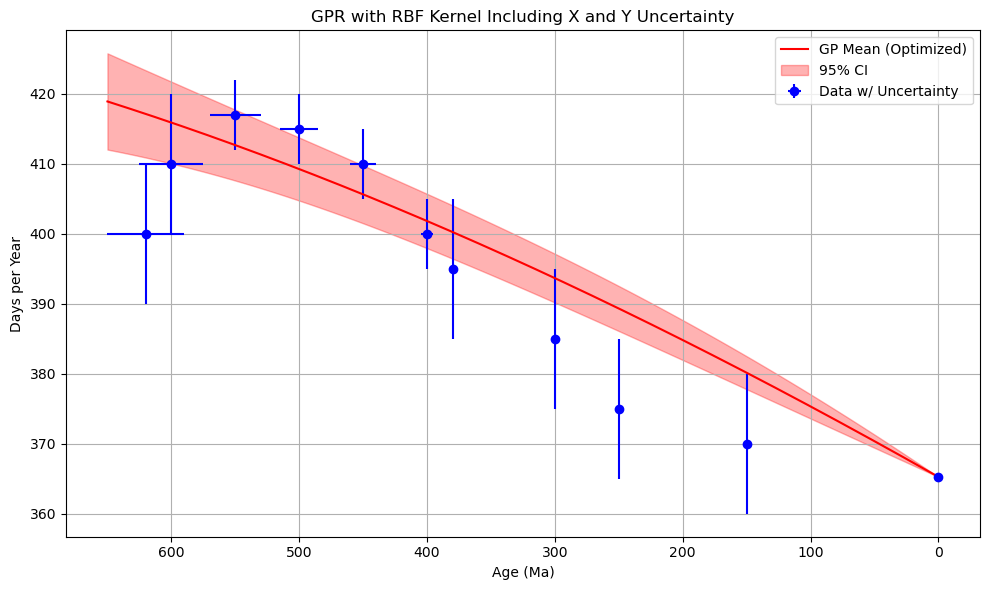

In [51]:
# Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_train = df["Days/year"].values.astype(float)
y_error = df["Days/year error"].values.astype(float)
x_error = df["Age error"].values.astype(float).reshape(-1, 1)

# Normalize X for better numerics
X_mean, X_std = X_train.mean(), X_train.std()
X_train_norm = (X_train - X_mean) / X_std
x_error_norm = x_error / X_std  # Scale x uncertainties too

# Modified RBF kernel including x_error
def rbf_kernel_with_xerr(X1, X2, xerr1, xerr2, lengthscale, variance):
    """RBF kernel that accounts for Gaussian uncertainty in X."""
    # Pairwise squared distance
    sqdist = (X1 - X2.T)**2
    # Total lengthscale squared for each pair
    total_var = lengthscale**2 + xerr1**2 + xerr2.T**2
    scale_factor = (lengthscale**2 / total_var)**0.5
    return variance * scale_factor * np.exp(-0.5 * sqdist / total_var)

# NLML function
def nlml(params):
    lengthscale = np.exp(params[0])
    variance = np.exp(params[1])
    noise_var = (y_error**2).flatten()
    
    K = rbf_kernel_with_xerr(X_train_norm, X_train_norm, x_error_norm, x_error_norm, lengthscale, variance)
    K += np.diag(noise_var + 1e-6)  # Add measurement noise in y
    
    try:
        L = cholesky(K)
        alpha = solve(L.T, solve(L, y_train))
        log_det_K = 2.0 * np.sum(np.log(np.diag(L)))
        return 0.5 * y_train.T @ alpha + 0.5 * log_det_K + 0.5 * len(X_train) * np.log(2 * np.pi)
    except np.linalg.LinAlgError:
        return 1e10  # Penalize non-PD matrices

# Optimize hyperparameters
res = minimize(nlml, x0=[0.0, 0.0], bounds=[(-5, 5), (-5, 10)], method='L-BFGS-B')
opt_lengthscale = np.exp(res.x[0])
opt_variance = np.exp(res.x[1])
print(f"Optimal lengthscale: {opt_lengthscale:.3f}, variance: {opt_variance:.3f}")

# Predictions
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
x_error_test = np.zeros_like(X_test_norm)  # Assume no horizontal error for prediction

K = rbf_kernel_with_xerr(X_train_norm, X_train_norm, x_error_norm, x_error_norm, opt_lengthscale, opt_variance)
K += np.diag((y_error**2).flatten() + 1e-6)
K_s = rbf_kernel_with_xerr(X_test_norm, X_train_norm, x_error_test, x_error_norm, opt_lengthscale, opt_variance)
K_ss = rbf_kernel_with_xerr(X_test_norm, X_test_norm, x_error_test, x_error_test, opt_lengthscale, opt_variance) + 1e-8 * np.eye(len(X_test))

L = cholesky(K)
alpha = solve(L.T, solve(L, y_train))
mu_s = K_s @ alpha
v = solve(L, K_s.T)
cov_s = K_ss - v.T @ v
std_s = np.sqrt(np.clip(np.diag(cov_s), 0, np.inf))

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(X_train.flatten(), y_train.flatten(),
             xerr=x_error.flatten(), yerr=y_error.flatten(),
             fmt='o', color='blue', label="Data w/ Uncertainty")
plt.plot(X_test, mu_s, 'r', label="GP Mean (Optimized)")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='95% CI')
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("GPR with RBF Kernel Including X and Y Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Constrain Gaussian Process Regression to enforce monotonicity
Following framework from Zhang et al. (https://arxiv.org/html/2507.06677v1)
but using a Maximum A Posteriori estimation for uncertainties instead of the Regularized Linear Randomize-Then-Optimize (RLRTO) described in the paper.

Script to play around with hyperparameters without optimization

In [56]:
# ----------------------------
# Data: replace with your digitized values if needed
# ----------------------------
X_obs = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_obs = df["Days/year"].values.astype(float)
y_err = df["Days/year error"].values.astype(float).reshape(-1, 1)  # obs std dev

# We'll treat Age (Ma) as the GP input (1D)
# Choose grid for representing the latent function f(x)
X_grid = np.linspace(0.0, 650.0, 300).reshape(-1,1)  # dense grid covering the domain

# ----------------------------
# Kernel: Squared Exponential (RBF)
# ----------------------------
def rbf(X1, X2, lengthscale=100.0, variance=200.0):
    # squared distances
    X1 = X1.reshape(-1,1); X2 = X2.reshape(-1,1)
    d2 = (X1**2).reshape(-1,1) + (X2**2).reshape(1,-1) - 2.0 * (X1 @ X2.T)
    return variance * np.exp(-0.5 * d2 / (lengthscale**2))

# Prior hyperparameters (you can tune or optimize these)
lengthscale = 120.0   # in Ma (bigger = smoother)
variance = 400.0 # in days^2 (bigger = more variance)

# Compute K on grid
K = rbf(X_grid, X_grid, lengthscale=lengthscale, variance=variance)
jitter = 1e-8 * np.eye(K.shape[0])
K += jitter

# Precompute Cholesky for applying K^{-1} efficiently
L_K = cholesky(K, lower=True)

# ----------------------------
# Linear operator mapping grid f -> predicted observables at X_obs
# We'll use linear interpolation (matrix) from grid to observation points
# ----------------------------
def build_interp_matrix(X_from, X_to):
    # X_from: grid, X_to: observation points
    # returns A shape (n_to, n_from) such that y_pred = A @ f_grid
    xf = X_from.ravel()
    xt = X_to.ravel()
    n_from = len(xf)
    n_to = len(xt)
    A = np.zeros((n_to, n_from))
    for i, x in enumerate(xt):
        if x <= xf[0]:
            A[i,0] = 1.0
        elif x >= xf[-1]:
            A[i,-1] = 1.0
        else:
            j = np.searchsorted(xf, x) - 1
            x0, x1 = xf[j], xf[j+1]
            w1 = (x - x0) / (x1 - x0)
            w0 = 1.0 - w1
            A[i, j] = w0
            A[i, j+1] = w1
    return A

A_obs = build_interp_matrix(X_grid, X_obs)   # maps f_grid -> y_pred at observations

# ----------------------------
# Monotonicity constraints: finite difference derivative >= 0
# Build linear operator D such that D @ f_grid = approximate derivative at midpoints
# and require D @ f_grid >= 0
# ----------------------------
xf = X_grid.ravel()
dx = np.diff(xf)  # spacing (non-uniform allowed)
n_grid = len(xf)
n_der = n_grid - 1
D = np.zeros((n_der, n_grid))
for i in range(n_der):
    # forward difference derivative at interval i: (f[i+1] - f[i]) / dx[i]
    D[i, i]   = -1.0 / dx[i]
    D[i, i+1] =  1.0 / dx[i]

# We want monotonic increasing with Age, so we keep D @ f_grid >= 0
lincon = LinearConstraint(D, lb=np.zeros(D.shape[0]), ub=np.full(D.shape[0], np.inf))

# ----------------------------
# Objective: negative log posterior (up to constant) for f_grid
#   0.5 * (f - m)^T K^{-1} (f - m) + 0.5 * sum((A_obs f - y_obs)^2 / sigma_y^2)
# We'll take prior mean m as a weak linear trend fitted to data (optional)
# ----------------------------
# set prior mean m: linear fit in x->y space (helps numerics)
coefs = np.polyfit(X_obs.ravel(), y_obs.ravel(), deg=1)
m_grid = np.polyval(coefs, X_grid.ravel()).reshape(-1,1)

# noise variances for obs (use y_err; if zero, set small floor)
sigma_y2 = np.clip((y_err.ravel())**2, 1e-6, None)
W_inv = np.diag(1.0 / sigma_y2)  # shape (n_obs, n_obs)

# Helper: compute K^{-1} @ v using cho_solve (stable)
def Kinv_dot(v):
    # v shape (..., n_grid) or (n_grid,)
    return cho_solve((L_K, True), v)

# Objective and gradient
def objective(f_vec):
    # f_vec is 1D array length n_grid
    f = f_vec.reshape(-1,1)
    r = f - m_grid
    # prior term: 0.5 * r^T K^{-1} r
    Ki_r = Kinv_dot(r)
    prior_term = 0.5 * float(r.T @ Ki_r)
    # data term: 0.5 * (A f - y)^T W_inv (A f - y)
    Af = A_obs @ f
    resid = Af - y_obs
    data_term = 0.5 * float(resid.T @ W_inv @ resid)
    return prior_term + data_term

def grad_obj(f_vec):
    f = f_vec.reshape(-1,1)
    r = f - m_grid
    # gradient prior: K^{-1} r
    grad_prior = Kinv_dot(r)  # shape (n_grid,1)
    # gradient data: A^T W_inv (A f - y)
    Af = A_obs @ f
    resid = Af - y_obs
    grad_data = A_obs.T @ (W_inv @ resid)
    grad = (grad_prior + grad_data).ravel()
    return grad

# ----------------------------
# Initial guess: posterior mean from unconstrained GP (conditioning on the data)
# Solve for unconstrained predictive mean on grid: m_grid + K_grid_obs K_obs_obs^{-1} (y - m_obs)
# where K_grid_obs = K(X_grid, X_obs), K_obs_obs from observations' induced kernel on obs points
# Simpler: compute by solving the linear system via interpolation mapping A_obs.
# We'll compute the MAP without monotonicity first as init.
# ----------------------------
# Build smaller matrices using grid->obs mapping to form the posterior:
K_gg = K  # (n_grid x n_grid)
K_gg_A_T = A_obs.T  # not direct kernel; easier to do direct conditioning via penalized formulation below
# Use the minimizer initial guess as m_grid
x0 = m_grid.ravel()

# ----------------------------
# Run constrained optimization
# ----------------------------
print("Starting constrained optimization (this may take some seconds)...")
res = minimize(fun=objective, x0=x0, jac=grad_obj, method='trust-constr',
               constraints=[lincon],
               options={'verbose': 2, 'maxiter': 500})
if not res.success:
    print("Optimization warning:", res.message)
f_map = res.x.reshape(-1,1)   # MAP estimate on grid

# ----------------------------
# Approximate posterior covariance at the MAP (Laplace-ish approximation)
# We approximate posterior covariance of f_grid as (K^{-1} + A^T W_inv A)^{-1}
# Use the matrix-free solve via Cholesky if feasible (here n_grid ~ 300 OK)
# ----------------------------
from scipy.linalg import cho_factor, cho_solve
B = K.copy()
# compute S = K @ A_obs.T @ W_inv @ A_obs @ K  not needed; instead compute inverse of
# H = K^{-1} + A^T W_inv A  => compute matrix H and invert via cholesky
# Build H explicitly (n_grid x n_grid)
H = cho_solve((L_K, True), np.eye(K.shape[0]))  # K^{-1}
H += A_obs.T @ W_inv @ A_obs
# invert H
L_H = cholesky(H, lower=True)
Cov_f = cho_solve((L_H, True), np.eye(H.shape[0]))  # approximate posterior covariance
std_f = np.sqrt(np.clip(np.diag(Cov_f), 0, np.inf)).reshape(-1,1)

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(10,6))
# Observed data with errorbars
plt.errorbar(X_obs.ravel(), y_obs.ravel(),
             xerr=None, yerr=y_err.ravel(), fmt='o', label='Observed data', color='k')

# MAP mean and 95% credible band
plt.plot(X_grid.ravel(), f_map.ravel(), color='C1', lw=2, label='Constrained GP (MAP)')
plt.fill_between(X_grid.ravel(),
                 (f_map.ravel() - 1.96*std_f.ravel()),
                 (f_map.ravel() + 1.96*std_f.ravel()),
                 color='C1', alpha=0.25, label='Approx. 95% CI')

# Also plot prior mean (linear) for reference
plt.plot(X_grid.ravel(), m_grid.ravel(), '--', color='gray', label='Prior mean (linear)')

plt.gca().invert_xaxis()  # consistent with geology plots (old on left)
plt.xlabel('Age (Ma)')
plt.ylabel('Days per Year')
plt.title('GP with monotonicity constraints (MAP estimate)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Starting constrained optimization (this may take some seconds)...


C:\Users\nwi213\AppData\Local\Temp\ipykernel_21424\509240079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prior_term = 0.5 * float(r.T @ Ki_r)


TypeError: only length-1 arrays can be converted to Python scalars